In [74]:
import hashlib as hasher
import random
import time
import matplotlib.pyplot as plt
from tabulate import tabulate

def hashbits(input):
    hash_obj = hasher.sha256()
    inputbytes = input.encode()
    #print(type(inputbytes))
    hash_obj.update(inputbytes)
    hashbytes = hash_obj.digest()
    return ''.join(f'{x:08b}' for x in hashbytes)

def hash(input):
    hash_obj = hasher.sha256()
    inputbytes = input.encode()
    #print(type(inputbytes))
    hash_obj.update(inputbytes)
    return hash_obj.hexdigest()

In [75]:
# multi-lottery
class Block:
    def __init__(self, data, creator=None, previous=None, time=0):
        self.data = data
        if previous is None:
            self.previous = None
            self.previous_hash = ""
            self.creator = Minter(0 , "0")
            self.height = 0
        else:
            self.previous = previous
            self.previous_hash = previous.hash
            self.creator = creator
            self.height = previous.height+1
        self.timestamp = time
        self.hash = self.hash_block()
        self.children = []

    def pos_hash(self):
        return hashbits(self.creator.name + self.previous_hash + str(self.timestamp))

    def hash_block(self):
        return hashbits(self.creator.name + str(self.data) + self.previous_hash + str(self.timestamp))

    def print(self):
      print(self.data + " "+ self.creator.name + " " + str(self.height))
        
class Blockchain:
    def __init__(self, genesis_data, difficulty):
        self.chain = []
        self.chain.append(Block(genesis_data))
        self.difficulty = difficulty
        self.size = 0
        self.totalStake = 0

    def lastBlock(self):
      max = self.chain[0].height
      for block in self.chain:
        if block.height > max:
          max = block.height
      maxes = [block for block in self.chain if block.height == max]
      r = random.choices(maxes, k=1)
      return r[0]

    def lastBlocks(self):
      max = self.chain[0].height
      for block in self.chain:
        if block.height > max:
          max = block.height
      maxes = [block for block in self.chain if block.height == max]
      return maxes
        
    def add(self, newBlock):
        self.chain.append(newBlock)
        newBlock.previous.children.append(newBlock)
        self.size +=1
        #newBlock.creator.stake+=1
    
    def isSmaller(self, hashStr, creator):
      #add this function
      # use int(hashStr[0:15],2) to convert the first 15 bits to int 
      # compare it with the difficulty, multiplicated by the creators stake
      if int(hashStr[0:15],2) < self.difficulty * (creator.stake+self.checkMiner(creator)):
        return True
      return False

    
    def checkMiner(self, miner, last=None):
      if last == None:
        last = self.lastBlock()
      count = 0
      while last!=None:
        if last.creator == miner:
          count += 1
        last = last.previous
      return count

class Minter:
  def __init__(self, stake, name, blockchain=None):
    self.initialstake=stake
    self.stake = stake
    self.name = name
    self.blockchain = blockchain
    
    if self.blockchain != None:
      self.blockchain.totalStake += self.stake
      self.lastBlock = blockchain.lastBlock()

  def updateLast(self):
    latest = self.blockchain.lastBlock()
    if latest.height > self.lastBlock.height:
        self.lastBlock = latest

  def PoSSolver(self, seconds):
    newBlock = Block(str(self.blockchain.size), self, self.lastBlock, seconds)
    h = newBlock.pos_hash()
    if self.blockchain.isSmaller(h,self):
      self.blockchain.add(newBlock)
      self.lastBlock = newBlock
      # stake power add 1 every time mined a new block
      self.stake=self.stake+10




In [76]:
# simulation
def simulation(miners, number, blockchain):
    start_time = time.time()
    while blockchain.size<number:
        for miner in miners:
            seconds = (time.time() - start_time)
            miner.updateLast()
            miner.PoSSolver(seconds)
            
# simmulation run 100 times
times=10
rounds=100
ml_initStakes=[0,0,0,0]
ml_resultStakes=[0,0,0,0]
ml_blockNum=[0,0,0,0]
ml_table=[["miner","initial stake","averge final stake","averge block founded"]]
ml_average_bn=[0,0,0,0]
ml_average_stakes=[0,0,0,0]

for i in range(0,times):
    bc = Blockchain("0" , 0.1)
    m1 = Minter(10 ,"m1", bc)
    m2 = Minter(5, "m2", bc)
    m3 = Minter(20, "m3", bc)
    m4 = Minter(2, "m4", bc)
    miners=[m1,m2,m3,m4]
    simulation(miners,rounds,bc)
   # print("{} initial stake: {} , found {} blocks, stake update to {}".format(miner.name,miner.initialstake,bc.checkMiner(miner),miner.stake))
    for x, miner in enumerate(miners):
        if i==1: 
            ml_initStakes[x]=miner.initialstake
            ml_resultStakes[x]=miner.initialstake+miner.stake
            ml_blockNum[x]=ml_blockNum[x]+bc.checkMiner(miner)
        else:
            ml_resultStakes[x]=ml_resultStakes[x]+miner.stake    
            ml_blockNum[x]=ml_blockNum[x]+bc.checkMiner(miner)
    print("round: ",i)
    
for i in range(0,4):
    name="m"+str(i+1)
    item=[name,ml_initStakes[i],ml_resultStakes[i]/times,ml_blockNum[i]/times]
    ml_average_bn[i]=ml_blockNum[i]/times
    ml_average_stakes[i]=ml_resultStakes[i]/times
    ml_table.append(item)
    

round:  0
round:  1
round:  2
round:  3
round:  4
round:  5
round:  6
round:  7
round:  8
round:  9


In [77]:
# compound pos
# split the reward for every attesters
class Block:
    def __init__(self, data, creator=None, previous=None, time=0):
        self.data = data
        if previous is None:
            self.previous = None
            self.previous_hash = ""
            self.creator = Minter(0 , "0")
            self.height = 0
        else:
            self.previous = previous
            self.previous_hash = previous.hash
            self.creator = creator
            self.height = previous.height+1
        self.timestamp = time
        self.hash = self.hash_block()
        self.children = []

    def pos_hash(self):
        return hashbits(self.creator.name + self.previous_hash + str(self.timestamp))

    def hash_block(self):
        return hashbits(self.creator.name + str(self.data) + self.previous_hash + str(self.timestamp))

    def print(self):
      print(self.data + " "+ self.creator.name + " " + str(self.height))
        
class Blockchain:
    def __init__(self, genesis_data, difficulty):
        self.chain = []
        self.chain.append(Block(genesis_data))
        self.difficulty = difficulty
        self.size = 0
        self.totalStake = 0
        self.attesters=[]

    def lastBlock(self):
      max = self.chain[0].height
      for block in self.chain:
        if block.height > max:
          max = block.height
      maxes = [block for block in self.chain if block.height == max]
      r = random.choices(maxes, k=1)
      return r[0]

    def lastBlocks(self):
      max = self.chain[0].height
      for block in self.chain:
        if block.height > max:
          max = block.height
      maxes = [block for block in self.chain if block.height == max]
      return maxes
        
    def add(self, newBlock):
        self.chain.append(newBlock)
        newBlock.previous.children.append(newBlock)
        self.size +=1
        #newBlock.creator.stake+=1
        
    def addAttesters(self, miner):
        self.attesters.append(miner)
        
    def isSmaller(self, hashStr, creator):
      #add this function
      # use int(hashStr[0:15],2) to convert the first 15 bits to int 
      # compare it with the difficulty, multiplicated by the creators stake
      if int(hashStr[0:15],2) < self.difficulty * (creator.stake+self.checkMiner(creator)):
        return True
      return False

    
    def checkMiner(self, miner, last=None):
      if last == None:
        last = self.lastBlock()
      count = 0
      while last!=None:
        if last.creator == miner:
          count += 1
        last = last.previous
      return count

class Minter:
  def __init__(self, stake, name, blockchain=None):
    self.initialstake=stake
    self.stake = stake
    self.name = name
    self.blockchain = blockchain
    
    if self.blockchain != None:
      self.blockchain.totalStake += self.stake
      self.lastBlock = blockchain.lastBlock()

  def updateLast(self):
    latest = self.blockchain.lastBlock()
    if latest.height > self.lastBlock.height:
        self.lastBlock = latest

  def PoSSolver(self, seconds):
    newBlock = Block(str(self.blockchain.size), self, self.lastBlock, seconds)
    h = newBlock.pos_hash()
    if self.blockchain.isSmaller(h,self):
      self.blockchain.add(newBlock)
      self.lastBlock = newBlock
      # stake power add 1 every time mined a new block
      self.stake=self.stake+5
      inflation=5/len(self.blockchain.attesters)
      for attester in self.blockchain.attesters:
            attester.stake=attester.stake+inflation

In [78]:
# simulation
def simulation(miners, number, blockchain):
    start_time = time.time()
    # add all attesters
    for miner in miners:
        bc.addAttesters(miner)
    while blockchain.size<number:
        for miner in miners:
            seconds = (time.time() - start_time)
            miner.updateLast()
            miner.PoSSolver(seconds)
  

# simmulation run 100 times
c_initStakes=[0,0,0,0]
c_resultStakes=[0,0,0,0]
c_blockNum=[0,0,0,0]
c_table=[["miner","initial stake","averge final stake","averge block founded"]]
c_average_bn=[0,0,0,0]
c_average_stakes=[0,0,0,0]

for i in range(0,times):
    bc = Blockchain("0" , 0.1)
    m1 = Minter(10 ,"m1", bc)
    m2 = Minter(5, "m2", bc)
    m3 = Minter(20, "m3", bc)
    m4 = Minter(2, "m4", bc)
    miners=[m1,m2,m3,m4]
    simulation(miners,rounds,bc)
   # print("{} initial stake: {} , found {} blocks, stake update to {}".format(miner.name,miner.initialstake,bc.checkMiner(miner),miner.stake))
    for x, miner in enumerate(miners):
        if i==1: 
            c_initStakes[x]=miner.initialstake
            c_resultStakes[x]=miner.initialstake+miner.stake
            c_blockNum[x]=c_blockNum[x]+bc.checkMiner(miner)
        else:
            c_resultStakes[x]=c_resultStakes[x]+miner.stake    
            c_blockNum[x]=c_blockNum[x]+bc.checkMiner(miner)
    print("round: ",i)

for i in range(0,4):
    item=["m"+str(i+1),c_initStakes[i],c_resultStakes[i]/times,c_blockNum[i]/times]
    c_average_bn[i]=c_blockNum[i]/times
    c_average_stakes[i]=c_resultStakes[i]/times
    c_table.append(item)

round:  0
round:  1
round:  2
round:  3
round:  4
round:  5
round:  6
round:  7
round:  8
round:  9


ml-pos
+---------+-----------------+----------------------+------------------------+
| miner   |   initial stake |   averge final stake |   averge block founded |
+=========+=================+======================+========================+
| m1      |              10 |                  276 |                   27.8 |
+---------+-----------------+----------------------+------------------------+
| m2      |               5 |                  118 |                   11.8 |
+---------+-----------------+----------------------+------------------------+
| m3      |              20 |                  361 |                   42   |
+---------+-----------------+----------------------+------------------------+
| m4      |               2 |                  182 |                   18.4 |
+---------+-----------------+----------------------+------------------------+
c-pos
+---------+-----------------+----------------------+------------------------+
| miner   |   initial stake |   averge final stake 

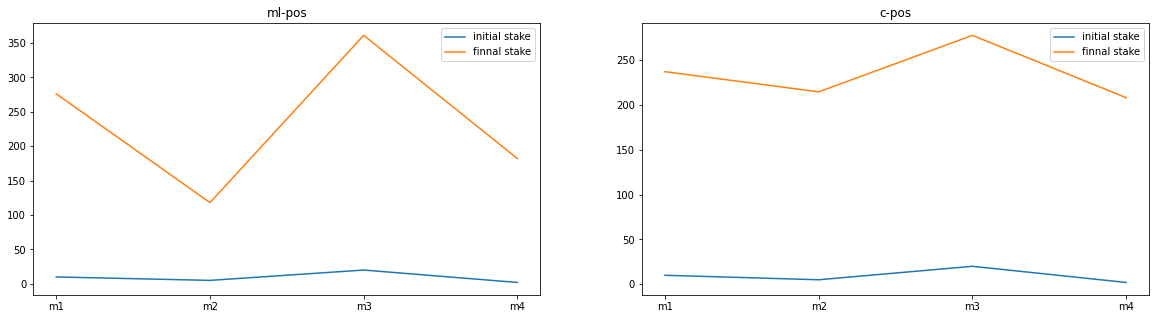

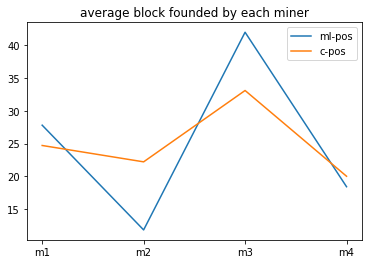

In [80]:
## plot
## tables
print("ml-pos")
print(tabulate(ml_table,headers='firstrow', tablefmt='grid'))
print("c-pos")
print(tabulate(c_table,headers='firstrow', tablefmt='grid'))

# create data
x=["m1","m2","m3","m4"]

# ml-pos
plt.figure(1,figsize=[20,5])
plt.subplot(121)
plt.plot(x,ml_initStakes,label = "initial stake")
plt.plot(x,ml_average_stakes, label = "finnal stake")
plt.title("ml-pos")
plt.legend()
# c-pos
plt.subplot(122)
plt.plot(x,c_initStakes,label = "initial stake")
plt.plot(x,c_average_stakes, label = "finnal stake")
plt.title("c-pos")
plt.legend()
# plot lines
plt.show()


## plot block number
plt.plot(x,ml_average_bn,label = "ml-pos")
plt.plot(x,c_average_bn, label = "c-pos")
plt.title("average block founded by each miner")
plt.legend()
plt.show()